# Reprojection Error as a function of frames used in calibration

I've been wondering how many frames I need to label, and whether I'll get significantly better results by
combining lables from multiple sonar/camera frames.

Additionally, it'll be useful to have the reprojection errors as a baseline as I clean up bits of the pipeline.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import cv2
import importlib
import itertools
import random

In [3]:
import rosbag
import cv_bridge

In [4]:
import imaging_sonar_calibration
import imaging_sonar_calibration.calibration as isc

In [5]:
import charuco_utils
import charuco_utils.charuco_utils
importlib.reload(charuco_utils.charuco_utils)

<module 'charuco_utils.charuco_utils' from '/home/parallels/raven_ws/src/charuco_utils/src/charuco_utils/charuco_utils.py'>

### Load in the data ...

In [7]:
%%bash
ls /media/psf/data01/raven_analysis/2021-07_sonar_calibration/20210711_HF/*.pkl
pwd

/media/psf/data01/raven_analysis/2021-07_sonar_calibration/20210711_HF/calibration_labels.pkl
/media/psf/data01/raven_analysis/2021-07_sonar_calibration/20210711_HF/camera_poses.pkl
/home/parallels/raven_ws/src/imaging_sonar_calibration/notebooks


In [8]:
hf_labels_20210402_004316 = "/media/psf/data01/raven_analysis/2021-07_sonar_calibration/20210711_HF/calibration_labels.pkl"
hf_labels = hf_labels_20210402_004316
hf_camera_poses = "/media/psf/data01/raven_analysis/2021-07_sonar_calibration/20210711_HF/camera_poses.pkl"

In [9]:
import pickle
with open(hf_labels, 'rb') as fp:
    data = pickle.load(fp)
    good_timestamps = data["good_timestamps"]
    skip_timestamps = data["skip_timestamps"]
    sonar_labels = data["sonar_labels"]
with open(hf_camera_poses, 'rb') as fp:
    camera_poses = pickle.load(fp)

### What is the distribution of available camera frames? Labeled camera frames?

In [10]:
# Coordinates provided by detect_charuco_board are of the board ORIGIN, which is on one corner.
# It's probably more intuitive to think of x/y position of the board CENTER, so find its
# position relative to the origin so we can use the camera rvec/tvec to transform the board
# center into the camera's frame.
board_name = "default_11x8_45mm"
aruco_dict, charuco_board = charuco_utils.charuco_utils.get_charuco_board(board_name)
center_x, center_y = charuco_utils.charuco_utils.get_board_center(charuco_board)


In [11]:
good_board_x = []
good_board_y = []
good_board_z = []

good_skew_x = []
good_skew_y = []

for ts in good_timestamps:
    rvec, tvec = camera_poses[ts]
    rot, _ = cv2.Rodrigues(rvec)

    # I want to know where the _center_ of the board is. 
    board_center = tvec + rot @ np.reshape([center_x, center_y, 0.0], (3, 1))
    good_board_x.append(board_center[0])
    good_board_y.append(board_center[1])
    good_board_z.append(board_center[2])
    
    # TODO: This is NOT the "right" way to do this;
    # Maybe what I care about is angle between the board's normal and the camera's optical axis.
    # Maybe it's possible to represent that as an angle and a magnitude, and then draw ellipses rather than circles?
    sonar_fwd_vec = rot @ np.reshape([0, 0, 1], (3,1))
    good_skew_x.append(sonar_fwd_vec[1])
    good_skew_y.append(-1*sonar_fwd_vec[2])

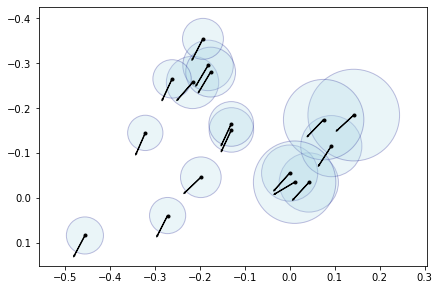

In [15]:
fig = plt.figure()
ax = fig.add_axes([0.05, 0.05, 0.9, 0.9])

for xx, yy, zz, sx, sy in zip(good_board_x, good_board_y, good_board_z, good_skew_x, good_skew_y):
    size = 0.1 / zz
    ww = size
    hh = size
    el = matplotlib.patches.Ellipse((xx, yy), width=ww, height=ww, facecolor='lightblue', edgecolor='navy', alpha=0.25)
    ax.add_patch(el)
    ax.plot(xx, yy, 'k.')
    ax.arrow(xx[0], yy[0], 0.05*sx[0], 0.05*sy[0])

ax.axis('equal')
# Flip axis to be more intuitive for human up/down, since this is in camera coordinates
ax.set_ylim(ax.get_ylim()[::-1])  
plt.show()


#### OK, let's plot ALL of the positions/angles for this bagfile!


In [16]:
# First, extract the poses from the bagfile
camera_topic = "/raven/stereo/left/image_raw"  # (In this bagfile, left/right were flipped)
camera_info = None
bridge = cv_bridge.CvBridge()
bagfile = "/media/psf/data01/raven_analysis/2021-07_sonar_calibration/raven_2021-04-02-00-43-16.bag"
all_poses = {}  # dict mapping timestamp to (rvec, tvec)
with open(bagfile, 'rb') as fp:
    bag = rosbag.Bag(fp)
    for topic, msg, tt in bag.read_messages():
        if camera_info is None and "camera_info" in topic:
            camera_info = msg
            continue
        if topic != camera_topic:
            continue
        camera_data = bridge.imgmsg_to_cv2(msg, "mono8")
        _, _, _, _, rvec, tvec = charuco_utils.charuco_utils.detect_charuco_board(
                aruco_dict, charuco_board, camera_data, camera_info)
        if rvec is not None and tvec is not None:
            all_poses[tt] = (rvec, tvec)

In [17]:
all_camera_poses = {tt: pp for tt, pp in all_poses.items() if pp[0] is not None}

In [18]:
# Next, let's extract the position + orientation info (copy-paste from above...)
all_board_x = []
all_board_y = []
all_board_z = []
all_skew_x = []
all_skew_y = []

for _, (rvec, tvec) in all_camera_poses.items():
    rot, _ = cv2.Rodrigues(rvec)

    # I want to know where the _center_ of the board is. 
    board_center = tvec + rot @ np.reshape([center_x, center_y, 0.0], (3, 1))
    all_board_x.append(board_center[0])
    all_board_y.append(board_center[1])
    all_board_z.append(board_center[2])
    
    # TODO: This is NOT the "right" way to do this;
    # Maybe what I care about is angle between the board's normal and the camera's optical axis.
    # Maybe it's possible to represent that as an angle and a magnitude, and then draw ellipses rather than circles?
    sonar_fwd_vec = rot @ np.reshape([0, 0, 1.0], (3,1))
    all_skew_x.append(sonar_fwd_vec[1])
    all_skew_y.append(-1*sonar_fwd_vec[2])

In [70]:
# Finally, plot ALL of the data:
fig = plt.figure()
ax = fig.add_axes([0.05, 0.05, 0.9, 0.9])

# Ideally, we wouldn't plot the points that were marked "good", but those are indexed by
# sonar timestamp, so I don't have a good way to match them back to the camera timestamps.
count = 0
for xx, yy, zz, sx, sy in zip(all_board_x, all_board_y, all_board_z, all_skew_x, all_skew_y):
    # Only plot every n-th camera pose, in order to make plot more interpretable.
    count += 1
    if count % 3 != 0:
        continue
    size = 0.1 / zz
    ww = size
    hh = size
    el = matplotlib.patches.Ellipse((xx, yy), width=ww, height=ww, 
                                    facecolor='lightgray', edgecolor='dimgray', alpha=0.25, zorder = 1)
    ax.add_patch(el)
    ax.plot(xx, yy, '.', color = 'dimgray', zorder=2)
    ax.arrow(xx[0], yy[0], 0.05*sx[0], 0.05*sy[0], color='dimgray', zorder=2)


for xx, yy, zz, sx, sy in zip(good_board_x, good_board_y, good_board_z, good_skew_x, good_skew_y):
    size = 0.1 / zz
    ww = size
    hh = size
    el = matplotlib.patches.Ellipse((xx, yy), width=ww, height=ww, 
                                    facecolor='lightcoral', edgecolor='maroon', alpha=0.25, zorder = 3)
    ax.add_patch(el)
    ax.plot(xx, yy, 'k.', zorder=4)
    ax.arrow(xx[0], yy[0], 0.05*sx[0], 0.05*sy[0], zorder=4)

ax.axis('equal')
# Flip axis to be more intuitive for human up/down, since this is in camera coordinates
ax.set_ylim(ax.get_ylim()[::-1])  
ax.set_title('Target poses from calibration dataset')
ax.set_xlabel('camera X (m)')
ax.set_ylabel('camera Y (m)')
plt.show()
fig.savefig("coverage.png", bbox_inches="tight")


<Figure size 432x288 with 0 Axes>

### How does reprojection error vary with number of labeled pairs?

For each proposed calibration + sensor pair, we calculate a reprojection error by projecting the opencv-detected charuco board location onto the sonar frame, and then comparing the expected pixel locations of the sonar targets with the labeled targets. 

This reports sum-squared pixel errors; for any further processing, we divide by the number of targets to get average per-target squared reprojection error. (Yeah, this is WONKY. Maybe I should use something else?)

* For each calibration approach, we will run up to 150 calibrations with randomly selected input.
  * Then, for each input set, calculate the reprojection error for every pair not used in the calibration.
    * Take the average of the left-out pairs 
  * Take the average of the averages

In [22]:
isc = importlib.reload(isc)

In [33]:
# Set starting conditions for minimization

init_rvec = np.reshape([1.2092, 1.2092, 1.2092], (3,1))  # Align the frames
#init_tvec = np.reshape([0, 0, 0], (3,1))  # If we want to test known-wrong.
init_tvec = np.reshape([0, 0.06, 0.095], (3,1))  # Original numbers
init_tvec = np.reshape([0, 0.051, 0.073], (3,1))  # From Jess

In [24]:
# Ugggh. Measuring the errors in "pixels" means that we need to know the resolution :-\
# Let's just grab the first sonar_image out of a handy bagfile. 
# (This is the same one that was labeled)
import rosbag
bagfile = "/media/psf/data01/raven_analysis/2021-07_sonar_calibration/raven_2021-04-02-00-43-16.bag"
with open(bagfile, 'rb') as fp:
    bag = rosbag.Bag(fp)
    for topic, msg, tt in bag.read_messages():
        if "sonar" in topic:
            sonar_image = msg
            break

range_resolution, angle_resolution = isc.get_sonar_resolution(sonar_image)

In [25]:
# Key is number of image pairs used to estimate the calibration, value is resulting errors 
# (sum-squared pixel errors, divided by number of labeled target points)
reprojection_errors = {}  # type: Dict[int, List[List[float]]]

calibration = {} # type: Dict[int, List[Pair(np.ndarray, np.ndarray)]]

#### First, compute reprojection error using displacements from the CAD model

In [34]:
reprojection_errors[0] = [[]]  # type: List[List[float]]
calibration[0] = [[(init_rvec, init_tvec)]]
    
for ts in good_timestamps:   
    # sonar_coords: [(angle_deg, range_m), ...]
    # target_points: [(x, y, z), ...]
    sonar_points, target_points = isc.get_sonar_target_correspondences(sonar_labels[ts])
    camera_rvec, camera_tvec = camera_poses[ts]
    camera_rot, _ = cv2.Rodrigues(camera_rvec)
    camera_points = camera_tvec + camera_rot @ target_points

    err = isc.calc_projection_error(camera_points, sonar_points, init_rvec, init_tvec,
                                    range_resolution, angle_resolution)
    reprojection_errors[0][0].append(err / len(sonar_labels[ts]))


#### Next, compute reprojection error for inversion based on a single sonar/camera pair

In [36]:
reprojection_errors[1] = []
calibration[1] = []
for idx, calib_ts in enumerate(good_timestamps):
    reprojection_errors[1].append([])
    calibration[1].append([])
    
    sonar_points, target_points = isc.get_sonar_target_correspondences(sonar_labels[calib_ts])
    if calib_ts not in camera_poses:
        print("ERROR: {} labeled good, but doesn't have saved camera poses!".format(calib_ts))
        continue
    camera_rvec, camera_tvec = camera_poses[calib_ts]
    camera_rot, _ = cv2.Rodrigues(camera_rvec)
    camera_points = camera_tvec + camera_rot @ target_points
    _, rvec, tvec = isc.calibrate_sonar(sonar_points, camera_points,
                                        range_resolution, angle_resolution,
                                        init_rvec, init_tvec, verbose=False)
    calibration[1][idx] = (rvec, tvec)

    for other_ts in good_timestamps:
        if other_ts == calib_ts:
            continue
        sonar_points, target_points = isc.get_sonar_target_correspondences(sonar_labels[other_ts])
        camera_rvec, camera_tvec = camera_poses[other_ts]
        camera_rot, _ = cv2.Rodrigues(camera_rvec)
        camera_points = camera_tvec + camera_rot @ target_points

        err = isc.calc_projection_error(camera_points, sonar_points, rvec, tvec,
                                        range_resolution, angle_resolution)
        reprojection_errors[1][idx].append(err / len(sonar_labels[other_ts]))


#### Finally, generalize it to N pairs

* for _ in range(150):
  * Select N pairs
    * Compute calibration based on all targets seen in those pairs
    * For all labeled pairs NOT selected
        * compute reprojection error

In [47]:
# 2 pairs means trying to use data from two image pairs for each calibration.
num_combos = 150  # Maximum number of random frame combintations to try for each npairs
for npairs in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
#for npairs in [6, 8, 9]:

    reprojection_errors[npairs] = []
    calibration[npairs] = []
    idx = 0
    combos = list(itertools.combinations(good_timestamps, npairs))
    for calib_timestamps in random.choices(combos, k=num_combos):
        reprojection_errors[npairs].append([])
        calibration[npairs].append([])

        sonar_points = None
        camera_points = None
    
        for calib_ts in calib_timestamps:
            sp, tp = isc.get_sonar_target_correspondences(sonar_labels[calib_ts])
            camera_rvec, camera_tvec = camera_poses[calib_ts]
            camera_rot, _ = cv2.Rodrigues(camera_rvec)
            cp = camera_tvec + camera_rot @ tp

            if sonar_points is None:
                sonar_points = sp
            else:
                sonar_points = np.append(sonar_points, sp, axis=1)
            if camera_points is None:
                camera_points = cp
            else:
                camera_points = np.append(camera_points, cp, axis=1)
    
        _, rvec, tvec = isc.calibrate_sonar(sonar_points, camera_points,
                                            range_resolution, angle_resolution,
                                            init_rvec, init_tvec, False)
        calibration[npairs][idx] = (rvec, tvec)
    
        for other_ts in good_timestamps:
            if other_ts in calib_timestamps:
                continue
            sonar_points, target_points = isc.get_sonar_target_correspondences(sonar_labels[other_ts])
            camera_rvec, camera_tvec = camera_poses[other_ts]
            camera_rot, _ = cv2.Rodrigues(camera_rvec)
            camera_points = camera_tvec + camera_rot @ target_points

            err = isc.calc_projection_error(camera_points, sonar_points, rvec, tvec,
                                            range_resolution, angle_resolution)
            reprojection_errors[npairs][idx].append(err / len(sonar_labels[other_ts]))
        idx += 1


Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not termina

Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not termina

Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not termina

Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not termina

Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not termina

Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not termina

Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not termina

#### Plot!

0 4.115846131193701
1 2.286177674782193
2 1.9588498144818505
3 1.7763218974655937
4 1.7243387646252362
5 1.6762654952383873
6 1.6391110183281519
7 1.59670448425481
8 1.590502211907238
9 1.5994810374263495
10 1.5733176810500276


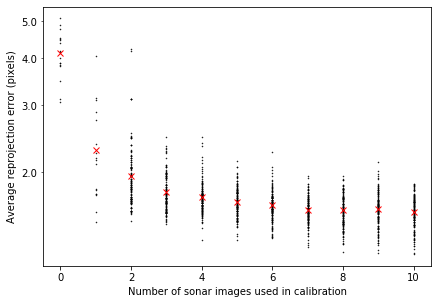

In [71]:
fig = plt.figure()
ax = fig.add_axes([0.05, 0.05, 0.9, 0.9])

for val in reprojection_errors[0][0]:
    plt.semilogy(0, val, 'k.', ms=1)
ax.semilogy(0, np.mean(reprojection_errors[0][0]), 'rx')
print(0, np.mean(reprojection_errors[0][0]))

for npairs in sorted(reprojection_errors.keys()):
    if npairs == 0:  # We already handled the initial-value case
        continue
    means = []
    for arr in reprojection_errors[npairs]:
        mm = np.mean(arr)
        ax.semilogy(npairs, np.mean(mm), 'k.', ms=1)
        means.append(mm)
    ax.semilogy(npairs, np.mean(means), 'rx')
    print(npairs, np.mean(means))
    
ax.set_xlabel("Number of sonar images used in calibration")
ax.set_ylabel("Average reprojection error (pixels)")
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

plt.show()
fig.savefig("reprojection_errors.png", bbox_inches="tight")

#### Finally, let's convert these calibrations to intuitive units and see how similar they are

In [362]:
import tf
import tf.transformations

In [363]:
# WTF. I'm computing the transformation between the LEFT camera and the sonar.
# tvec[0] is clearly forward/back.
# a fwd/down/port reference frame would work with the signs ... but it has issues:
#   * It's not used anywhere!
#   * I thought that 0.48 was the horizontal displacement

# rvec, tvec should go from camera to sonar
# sonar = tvec + rvec @ camera
rvec, tvec

(array([[1.34801189],
        [1.30941923],
        [1.13491835]]),
 array([[0.00606422],
        [0.04821803],
        [0.07688688]]))

In [366]:
# TODO: I'm pretty sure that this isn't right -- I can't figure out how to get those euler rotations to work.
rot, _ = cv2.Rodrigues(rvec)
yaw, pitch, roll = tf.transformations.euler_from_matrix(np.transpose(rot))

dx, dy, dz = tvec[0][0], tvec[1][0], tvec[2][0]
print("Final ROS XYZ: {:03f} {:03f} {:03f}".format(dx, dy, dz))
print("Final ROS YPR: {:03f} {:03f} {:03f}".format(yaw, pitch, roll))


Final ROS XYZ: 0.006064 0.048218 0.076887
Final ROS YPR: -3.083024 -1.408555 1.491988


### How much do the calibrations vary as a function of images used?

In [73]:
# Collect data to plot variance of the inversions
npairs = 5
xx = []
yy = []
zz = []
d_roll = []
d_pitch = []
d_yaw = []
errors = []

dx, dy, dz, yaw, pitch, roll = None, None, None, None, None, None
for idx in random.choices(range(len(calibration[npairs])), k=100):
    (rvec, tvec) = calibration[npairs][idx]
    rot, _ = cv2.Rodrigues(rvec)
    dx, dy, dz = tvec[0][0], tvec[1][0], tvec[2][0]
    xx.append(dx)
    yy.append(dy)
    zz.append(dz)
    
    sonar_fwd_vec = rot @ np.reshape([0, 0, 1], (3,1))
    pitch = np.arcsin(sonar_fwd_vec[2])
    d_pitch.append(pitch)
    
    yaw = np.arcsin(sonar_fwd_vec[1])
    d_yaw.append(yaw)
    
    sonar_stbd_vec = rot @ np.reshape([1, 0, 0], (3,1))
    roll = np.arcsin(sonar_stbd_vec[2])
    d_roll.append(roll)
    
    errors.append(np.mean(reprojection_errors[npairs][idx]))
    
print("Final ROS XYZ: {:03f} {:03f} {:03f}".format(dx, dy, dz))
print("Final ROS YPR: {:03f} {:03f} {:03f}".format(np.degrees(yaw[0]), np.degrees(pitch[0]), np.degrees(roll[0])))

Final ROS XYZ: 0.003437 0.049044 0.081728
Final ROS YPR: -0.616054 -6.708606 1.064362


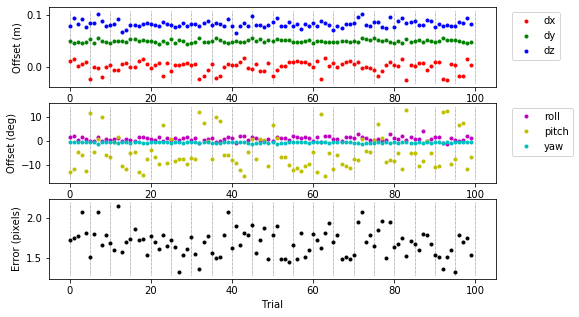

In [111]:
fig = plt.figure(figsize=(8, 5))
#ax = fig.add_axes([0.05, 0.05, 0.9, 0.9])

translation_ax = fig.add_subplot(3,1,1)
rotation_ax = fig.add_subplot(3,1,2)
error_ax = fig.add_subplot(3,1,3)

translation_ax.plot(xx, 'r.')
translation_ax.plot(yy, 'g.')
translation_ax.plot(zz, 'b.')
translation_ax.legend(["dx", "dy", "dz"], bbox_to_anchor=(1.025, 1.0), loc='upper left')
translation_ax.set_ylabel("Offset (m)")

rotation_ax.plot(np.degrees(d_roll), 'm.')
rotation_ax.plot(np.degrees(d_pitch), 'y.')
rotation_ax.plot(np.degrees(d_yaw), 'c.')
rotation_ax.set_ylabel("Offset (deg)")

rotation_ax.legend(["roll", "pitch", "yaw"], bbox_to_anchor=(1.025, 1.0), loc='upper left')

error_ax.plot(errors, 'k.')
error_ax.set_ylabel("Error (pixels)")
error_ax.set_xlabel("Trial")

for ax in [translation_ax, rotation_ax, error_ax]:
    ylim = ax.get_ylim()
    ax.vlines(np.arange(0, 101, 5), ylim[0], ylim[1], linestyles='dotted', linewidth=0.5)

plt.show()
fig.savefig("calib_stability.png", bbox_inches="tight")



In [69]:
print("Avg dx = {:.03f} +- {:.03f}, dy = {:.03f} +- {:.03f}, dz = {:.03f} +- {:.03f}"
      .format(np.mean(xx), np.std(xx), np.mean(yy), np.std(yy), np.mean(zz), np.std(zz)))
print("Avg roll = {:.03f} +- {:.03f}, pitch = {:.03f} +- {:.03f}, yaw = {:.03f} +- {:.03f}"
      .format(np.mean(np.degrees(d_roll)), np.std(np.degrees(d_roll)), 
              np.mean(np.degrees(d_pitch)), np.std(np.degrees(d_pitch)), 
              np.mean(np.degrees(d_yaw)), np.std(np.degrees(d_yaw))))

Avg dx = -0.001 +- 0.011, dy = 0.050 +- 0.003, dz = 0.082 +- 0.007
Avg roll = 0.653 +- 0.943, pitch = -3.201 +- 7.471, yaw = -0.654 +- 0.198


So, initialized with [0, 0.051, 0.073], we get:

Avg dx = -0.001 +- 0.011, dy = 0.050 +- 0.003, dz = 0.082 +- 0.007

Avg roll = 0.653 +- 0.943, pitch = -3.201 +- 7.471, yaw = -0.654 +- 0.198


### Finally, reformat it to work with ROS!

In [79]:
# Let's go ahead and use ALL of the image pairs for calibration
sonar_points = None
camera_points = None
    
for calib_ts in good_timestamps:
    sp, tp = isc.get_sonar_target_correspondences(sonar_labels[calib_ts])
    camera_rvec, camera_tvec = camera_poses[calib_ts]
    camera_rot, _ = cv2.Rodrigues(camera_rvec)
    cp = camera_tvec + camera_rot @ tp

    if sonar_points is None:
        sonar_points = sp
    else:
        sonar_points = np.append(sonar_points, sp, axis=1)
    if camera_points is None:
        camera_points = cp
    else:
        camera_points = np.append(camera_points, cp, axis=1)
    
_, rvec, tvec = isc.calibrate_sonar(sonar_points, camera_points,
                                    range_resolution, angle_resolution,
                                    init_rvec, init_tvec, False)


Optimization did not terminate successfully, or error too large. Trying 2nd pass
Optimization did not terminate successfully, or error too large. Trying 2nd pass


In [81]:
tvec

array([[0.00776897],
       [0.04895711],
       [0.07968067]])

In [100]:
np.random.randint(4)

3

### What about if we only use one or two features from each image?


In [109]:
sonar_points = None
camera_points = None

count = 0
    
for calib_ts in good_timestamps:
    sp, tp = isc.get_sonar_target_correspondences(sonar_labels[calib_ts])
    camera_rvec, camera_tvec = camera_poses[calib_ts]
    camera_rot, _ = cv2.Rodrigues(camera_rvec)
    cp = camera_tvec + camera_rot @ tp
    
    pt_idx = np.random.randint(len(sp[0]))
    
    if sonar_points is None:
        sonar_points = [[sp[0][pt_idx]], [sp[1][pt_idx]]]
    else:
        sonar_points = np.append(sonar_points, [[sp[0][pt_idx]], [sp[1][pt_idx]]], axis=1)
    if camera_points is None:
        camera_points = [[cp[0][pt_idx]], [cp[1][pt_idx]], [cp[2][pt_idx]]]
    else:
        camera_points = np.append(camera_points, [[cp[0][pt_idx]], [cp[1][pt_idx]],  [cp[2][pt_idx]]], axis=1)
        

print(len(sonar_points[0]))
print(sonar_points)
    
tvec_0 = np.reshape([0, 0, 0], (3,1))  # If we want to test known-wrong.

_, rvec, tvec = isc.calibrate_sonar(sonar_points, camera_points,
                                    range_resolution, angle_resolution,
                                    init_rvec, tvec_0, False)


17
[[ 0.32426945 -0.05528628  0.21874441 -0.40009652 -0.00154693  0.15800866
   0.16003512 -0.13790468 -0.04273035 -0.17365093 -0.07743962 -0.03862685
   0.04456541 -0.12395836 -0.30352223 -0.29171276 -0.26166001]
 [ 0.84128433  0.80874346  0.87094193  0.94525128  0.86323854  0.94038965
   0.93886528  0.69150366  1.29743324  1.29812828  0.48184527  0.53966631
   1.13172134  1.24097001  1.19485597  1.08778983  0.53009344]]


In [110]:
rvec, tvec

(array([[1.05292924],
        [1.04991545],
        [1.28298955]]),
 array([[-0.02449024],
        [ 0.05469889],
        [ 0.08820779]]))

In [108]:
init_tvec

array([[0.   ],
       [0.051],
       [0.073]])

In [380]:
cam_fwd = np.reshape([0, 0, 1],(3,1))
tvec + rot@cam_fwd
# [0.993, 0.039, -0.08]
# OK, forward on camera does map to forward on the sonar

array([[ 0.99293187],
       [ 0.03876273],
       [-0.08436704]])

In [381]:
cam_left = np.reshape([-0.25, 0, 1], (3,1))
tvec + rot@cam_left
# Yup! still consistent with sonar being fwd/stbd/down

array([[ 0.98975265],
       [-0.21117093],
       [-0.08916862]])

In [382]:
cam_up_right = np.reshape([0.25, -0.25, 1], (3,1))
tvec + rot@cam_up_right
# And, still consistent... so I'm convinced that at least the rotation matrix is correct.

array([[ 0.95585371],
       [ 0.29394758],
       [-0.32624698]])

In [387]:
# What if we input the rotation I calculated as the prior?
init_rot, _ = cv2.Rodrigues(init_rvec)
print(init_rot@cam_fwd)
tvec + init_rot@cam_fwd
# => yup, all of the vectors are still in the correct directions, so it's just tvec that's weird.

# Ah-hah! I checked, and while the TOPIC may be "left", the images are definitely "right". 
# So, this bag file that I'm working with is most definitely one of the borked ones, and there's
# nothing wrong with the calibration.

[[ 1.00000000e+00]
 [ 4.23843945e-07]
 [-4.23843765e-07]]


array([[1.00606422],
       [0.04821845],
       [0.07688645]])

In [386]:
tvec + init_rot@cam_up_right

array([[ 1.006064  ],
       [ 0.29821856],
       [-0.17311344]])

In [393]:
np.arctan2(0.5, 1)

0.4636476090008061

### Simply plotting an image

In [68]:
import rosbag
import numpy as np
import matplotlib.pyplot as plt

In [70]:
#bag = rosbag.Bag(open('/media/parallels/data01/raven_data/2021-07-13_sonar_target_size/oculus_2021-07-13-19-30-56.bag', 'rb'))
bag = rosbag.Bag('/home/parallels/raven_data/2021-04-16_sonar_mr_easter/raven_2021-04-16-19-27-43.bag')

In [72]:
for topic, msg, tt in bag.read_messages():
    if 'sonar' in topic:
        break

In [569]:
bag.close()

In [73]:
msg.intensities

b'\x16\x17\x17\x16\x16\x15\x15\x15\x14\x12\x11\x10\x0f\r\x0b\n\x08\x08\x04\x03\x06\x07\t\x08\t\n\n\n\t\t\t\x07\x05\x04\x03\x03\x04\x07\x08\x06\x08\x08\x08\x08\x07\x06\x05\x06\x03\x02\x05\x05\x06\x07\x07\x07\x07\x05\x05\x03\x01\x02\x02\x05\x04\x06\x06\x06\x06\x05\x05\x03\x03\x02\x04\x03\x05\x05\x06\x05\x04\x05\x03\x02\x02\x01\x04\x02\x03\x04\x05\x05\x05\x04\x04\x02\x02\x02\x03\x04\x04\x04\x04\x01\x02\x01\x04\x05\x04\x02\x02\x04\x04\x03\x03\x05\x03\x03\x03\x04\x04\x02\x04\x02\x02\x03\x02\x02\x01\x03\x02\x02\x01\x02\x01\x02\x03\x02\x01\x03\x01\x03\x01\x02\x03\x03\x02\x01\x04\x03\x02\x02\x02\x03\x03\x04\x04\x03\x03\x02\x03\x02\x04\x04\x04\x04\x04\x03\x03\x04\x03\x03\x03\x03\x05\x05\x05\x05\x04\x04\x02\x05\x03\x03\x03\x05\x05\x06\x06\x06\x06\x04\x05\x03\x04\x04\x05\x06\x05\x07\x06\x07\x07\x05\x04\x05\x02\x02\x05\x04\x05\x07\x07\x08\x08\x08\x07\x08\x08\x05\x03\x02\x04\x05\x07\t\t\n\x0b\x0b\x0b\n\t\n\x08\x06\x04\x03\x07\x06\t\n\x0c\x0e\x10\x11\x12\x13\x14\x15\x15\x16\x16\x17\x18\x17\r\r\x0e\x

In [74]:
len(msg.intensities) / 256.

706.0

In [75]:
data = [int(foo) for foo in msg.intensities]
data = np.reshape(data, (-1, 256))

In [76]:
plt.imshow(data)

In [ ]:
bag.close()

In [77]:
len(msg.azimuth_angles)

256

In [79]:
len(msg.ranges)

706

In [80]:
data

array([[22, 23, 23, ..., 23, 24, 23],
       [13, 13, 14, ..., 13, 12, 13],
       [10,  9,  8, ...,  9,  9,  9],
       ...,
       [37, 28, 27, ..., 40, 28, 21],
       [37, 33, 29, ..., 25, 18, 34],
       [33, 26, 23, ..., 32, 29, 33]])

In [84]:
data[:,-1]

array([23, 13,  9,  7,  2,  2,  3,  3,  3,  1,  2,  3,  3,  3,  3,  2,  2,
        3,  2,  2,  3,  2,  2,  2,  2,  2,  2,  2,  2,  1,  3,  3,  2,  2,
        2,  2,  3,  3,  2,  3,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  3,  3,  2,  3,  3,  2,  2,  3,  2,  2,  3,  2,  3,  2,  2,
        3,  2,  3,  3,  3,  3,  4,  3,  3,  3,  3,  3,  2,  1,  2,  2,  2,
        3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  3,
        4,  4,  3,  4,  4,  4,  4,  5,  4,  4,  5,  4,  5,  4,  4,  4,  4,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  3,  3,  5,  4,  3,  3,  2,
        2,  4,  2,  4,  2,  3,  3,  4,  2,  5,  2,  3,  3,  4,  3,  3,  3,
        3,  2,  3,  2,  4,  1,  2,  2,  3,  4,  4,  1,  4,  4,  2,  2,  5,
        2,  2,  4,  4,  4,  3,  4,  3,  3,  6,  4,  4,  4,  5,  4,  4,  5,
        5,  5,  3,  3,  4,  5,  6,  4,  5,  3,  3,  3,  4,  7,  5,  6,  4,
        6,  7,  6,  4,  6,  4,  5,  2,  4,  6,  3,  5,  1,  5,  3,  6,  4,
        4,  3,  4,  7,  4